In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from scipy.stats import mstats
import statsmodels.api as sm
from scipy.stats import boxcox

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [17]:
df = pd.read_excel('./florida_2017.xls')
headers = ['city', 'population', 'violent_crime', 'murder', 'rape', 'robbery',
       'assault', 'property_crime', 'burglary', 'larceny_theft',
       'motor_vehicle_theft', 'arson']
df.columns = headers
df.set_index('city', inplace=True)

crime_cols = ['violent_crime', 'murder', 'rape', 'robbery', 
              'assault', 'property_crime', 'burglary', 'larceny_theft', 
              'motor_vehicle_theft', 'arson']

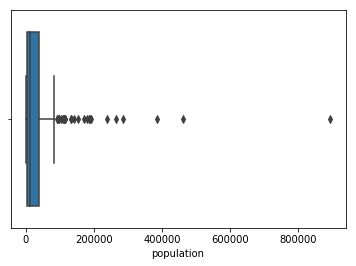

In [3]:
sns.boxplot(df.population)

In [4]:
# so we will want to remove some outliers
df = df[df.population<df.population.quantile(0.9)]

# log population
df["population_log"] = np.log(df.population)
# log1p first adds 1 to x then logs the result
df["property_crime_log"] = np.log1p(df.property_crime)
# square population
df["population_squared"] = df.population**2
df["population_cube_root"] = df.population**(1/3)
# create robbery dummy var
df["has_robbery"] = np.where(df.robbery>0,1,0)
# create a murder category
df["has_murder"] = np.where(df.murder>0, 1, 0)
df["has_assault"] = np.where(df.assault>0, 1, 0)

In [5]:
df.skew()

population              1.351
violent_crime           2.825
murder                  4.326
rape                    2.413
robbery                 3.483
assault                 3.108
property_crime          1.987
burglary                1.883
larceny_theft           1.998
motor_vehicle_theft     2.768
arson                   2.211
population_log         -0.386
property_crime_log     -0.585
population_squared      2.300
population_cube_root    0.379
has_robbery            -1.509
has_murder              0.548
has_assault            -2.965
dtype: float64

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


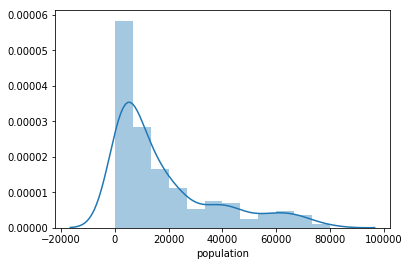

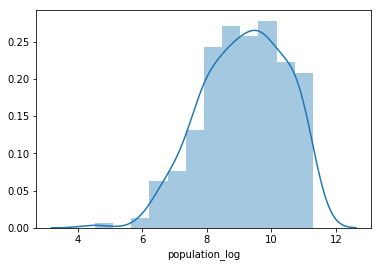

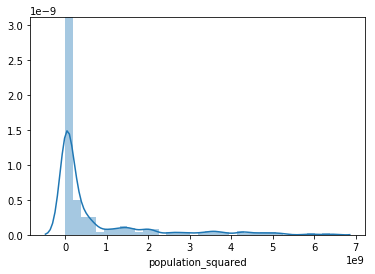

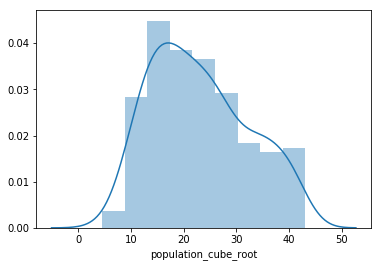

In [6]:
sns.distplot(df.population)
plt.show()
sns.distplot(df.population_log)
plt.show()
sns.distplot(df.population_squared)
plt.show()
sns.distplot(df.population_cube_root)
plt.show()

*Cube root of population looks to be the best to use in place of population.*

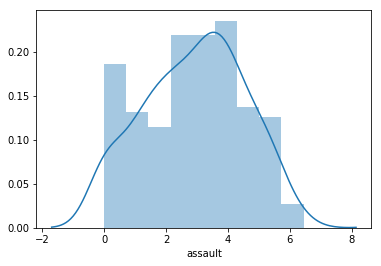

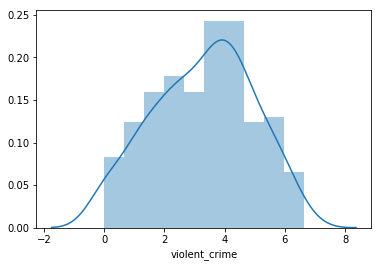

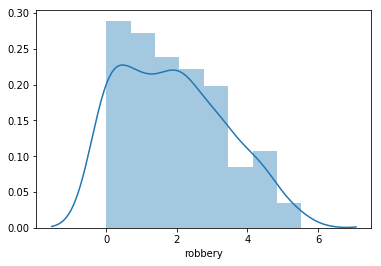

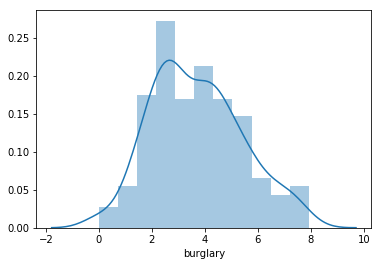

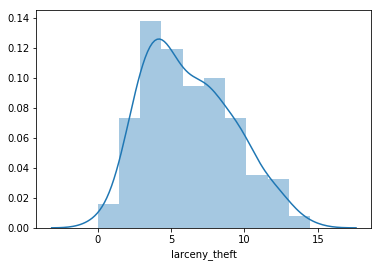

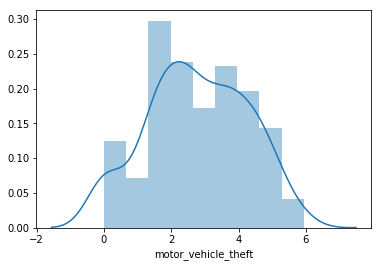

In [7]:
# split into population groups
df["population_low"] = (df.population < 3620.0).astype("int")
df["population_medium"] = (df.population.between(3620.0, 24929.5)).astype("int")
df["population_high"] = (df.population >= 24929.5).astype("int")

sns.distplot(np.log1p(df.assault))
df["assault_log"] = np.log1p(df.assault)
plt.show()
sns.distplot(np.log1p(df.violent_crime))
df["violent_crime_log"] = np.log1p(df.violent_crime)
plt.show()
sns.distplot(np.log1p(df.robbery))
df["robbery_log"] = np.log1p(df.robbery) 
plt.show()
sns.distplot(df.burglary**(1/3))
df["burglary_cube_root"] = df.burglary**(1/3)
plt.show()
sns.distplot(df.larceny_theft**(1/3))
df["larceny_theft_cube_root"] = df.larceny_theft**(1/3)
plt.show()
sns.distplot(np.log1p(df.motor_vehicle_theft))
df["motor_vehicle_theft_log"] = np.log1p(df.motor_vehicle_theft)
plt.show()

# Split

In [8]:
train = df.sample(frac=0.7, random_state=41)
test_cities = list(set(df.index).difference(set(train.index)))
test = df.loc[test_cities,:]
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (178, 27)
Test shape: (77, 27)


# Model

In [22]:
model_vars = ['population_log', 'has_robbery', 
              'population_medium', "burglary_cube_root", 
              "assault_log", "larceny_theft_cube_root", "robbery_log"]

formula1 = "property_crime ~ " + ' + '.join(model_vars)
lm1 = smf.ols(formula=formula1, data=train).fit()
lm1.summary()

NameError: name 'train' is not defined

In [10]:
model_vars2 = ['population_log', 'has_robbery', 
              'population_medium',
              "robbery_log", "burglary_cube_root",
              "larceny_theft_cube_root", "motor_vehicle_theft_log"]

formula2 = "property_crime_log ~ " + ' + '.join(model_vars2)
lm2 = smf.ols(formula=formula2, data=train).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     property_crime_log   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     876.1
Date:                Tue, 11 Dec 2018   Prob (F-statistic):          8.37e-130
Time:                        23:57:16   Log-Likelihood:                -15.446
No. Observations:                 178   AIC:                             46.89
Df Residuals:                     170   BIC:                             72.35
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.0135      0.289      3.504      0.001       0.443       1.585
population_log              0.1061      0.044      2.432      0.016       0.020       0.192
has_robbery                 0.5123      0.068      7.531      0.000       0.378       0.647
population_medium           0.3367      0.044      7.719      0.000       0.251       0.423
robbery_log                -0.1680      0.038     -4.424      0.000      -0.243      -0.093
burglary_cube_root          0.2229      0.035      6.290      0.000       0.153       0.293
larceny_theft_cube_root     0.3276      0.024     13.410      0.000       0.279       0.376
motor_vehicle_theft_log     0.1081      0.038      2.874      0.005       0.034       0.182
==============================================================================
Omnibus:                       51.131   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.919
Skew:                          -1.191   Prob(JB):                     1.13e-30
Kurtosis:                       6.595   Cond. No.                         187.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Evaluate

In [19]:
predicted1 = lm1.predict(test)
actual1 = test["property_crime"]
residuals1 = actual1 - predicted1

print("MODEL EVALUATION\n--------------------\nr^2: 0.973")
print("\nTRAIN\n--------------------")
print("Mean Residual: {}".format(lm1.resid.mean()))
print("RMSE: {}".format(round(lm1.resid.std()),2))

print("\n\nTEST\n--------------------")
print("Mean Residual: {}".format(residuals1.mean()))
print("RMSE: {}".format(round(residuals1.std()),2))

MODEL EVALUATION
--------------------
r^2: 0.973

TRAIN
--------------------
Mean Residual: -4.017999416329699e-12
RMSE: 214.0


TEST
--------------------
Mean Residual: -19.97054107469807
RMSE: 206.0


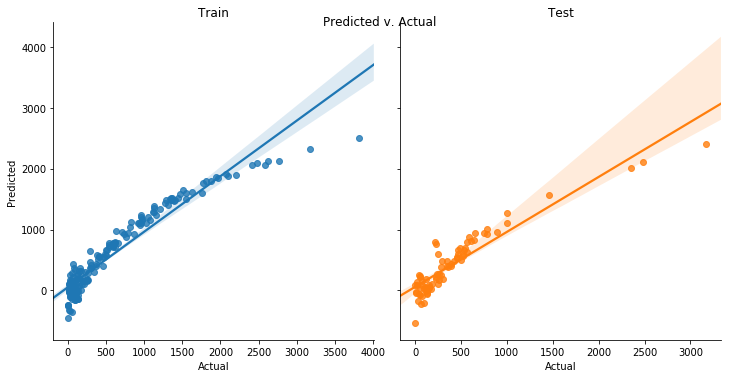

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.tight_layout()
fig.suptitle("Predicted v. Actual")
sns.regplot(train["property_crime"], lm1.fittedvalues, ax=ax1)
ax1.set_title("Train")
sns.despine(ax=ax1)

sns.regplot(actual1, predicted1, ax=ax2)
ax1.set(xlabel="Actual", ylabel="Predicted")
sns.despine(ax=ax2)
ax2.set_xlabel("Actual")
ax2.set_title("Test")
plt.show()

*Remember that for model 2 that we are predicting the log of property crime, so we need to exponentiate the predicted values.*

In [14]:
predicted2 = lm2.predict(test)
actual2 = test["property_crime_log"]
residuals2 = actual2 - predicted2

print("MODEL EVALUATION\n--------------------\nr^2: 0.973")
print("\nTRAIN\n--------------------")
print("Mean Residual: {}".format(np.exp(lm2.resid.mean())))
print("RMSE: {}".format(round(np.exp(lm2.resid.std()),2)))

print("\n\nTEST\n--------------------")
print("Mean Residual: {}".format(np.exp(residuals2.mean())))
print("RMSE: {}".format(round(np.exp(residuals2.std()),2)))

MODEL EVALUATION
--------------------
r^2: 0.973

TRAIN
--------------------
Mean Residual: 1.0000000000000004
RMSE: 1.3


TEST
--------------------
Mean Residual: 1.0210494782229915
RMSE: 1.4


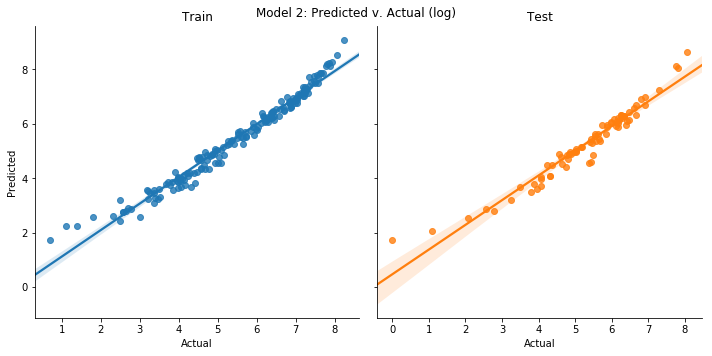

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.suptitle("Model 2: Predicted v. Actual (log)")
sns.regplot(train["property_crime_log"], lm2.fittedvalues, ax=ax1)
ax1.set_title("Train")
sns.despine(ax=ax1)

sns.regplot(actual2, predicted2, ax=ax2)
ax1.set(xlabel="Actual", ylabel="Predicted")
sns.despine(ax=ax2)
ax2.set_xlabel("Actual")
ax2.set_title("Test")
fig.tight_layout()
plt.show()

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


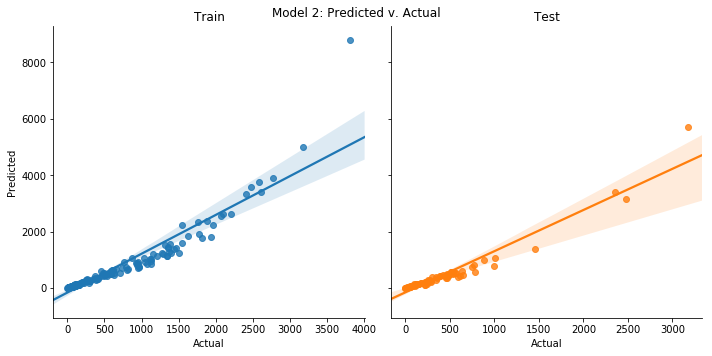

In [17]:
predicted3 = np.exp(lm2.predict(test))
actual3 = test["property_crime"]
residuals3 = actual3 - predicted3

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.suptitle("Model 2: Predicted v. Actual")
sns.regplot(train["property_crime"], np.exp(lm2.fittedvalues), ax=ax1)
ax1.set_title("Train")
sns.despine(ax=ax1)

sns.regplot(actual3, predicted3, ax=ax2)
ax1.set(xlabel="Actual", ylabel="Predicted")
sns.despine(ax=ax2)
ax2.set_xlabel("Actual")
ax2.set_title("Test")
fig.tight_layout()
plt.show()

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


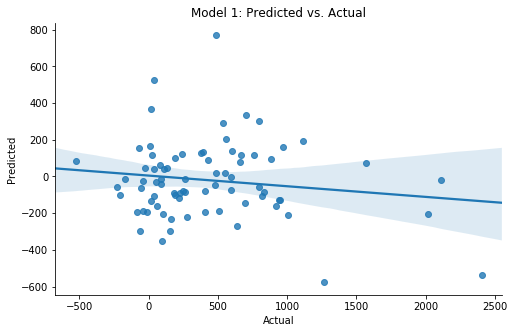

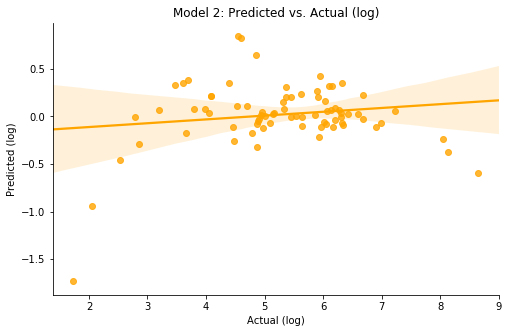

In [54]:
plt.figure(figsize=(8,5))
sns.regplot(predicted1, residuals1, fit_reg = True)
plt.xlabel("Actual")
plt.ylabel("Predicted")
sns.despine()
plt.title("Model 1: Predicted vs. Actual")
plt.show()

plt.figure(figsize=(8,5))
sns.regplot(predicted2, residuals2, fit_reg = True, color="orange")
plt.xlabel("Actual (log)")
plt.ylabel("Predicted (log)")
sns.despine()
plt.title("Model 2: Predicted vs. Actual (log)")
plt.show()

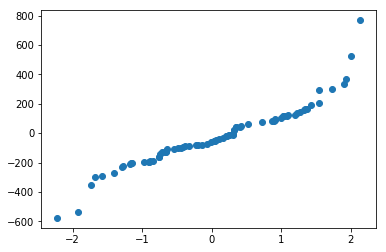

In [31]:
norm = np.random.normal(0,1,len(residuals1))
norm.sort()

residuals1.values.sort()
plt.scatter(norm, residuals1)
plt.show()

# Conclusion
The actual versus predicted plot (for the first model), shows us that the property crime variable is only linear up until a certain point (lets call this the saturation point). A linear model does not make sense for all cities; separate models should be used according to the population.

# Validate
We are using crime data from the state of Ohio, for 2017, to validate our model(s).

In [34]:
# Use Ohio crime data (2017) to validate model
ohio = pd.read_excel('./ohio_2017.xls')
ohio.columns = headers
ohio.set_index('city', inplace=True)
ohio = ohio[ohio.population < ohio.population.quantile(0.9)]

In [35]:
ohio["population_log"] = np.log(ohio.population)
ohio["population_medium"] = (ohio.population.between(3566.0, 13972.0))
ohio["has_robbery"] = np.where(ohio.robbery>0, 1, 0)
ohio["robbery_log"] = np.log1p(ohio.robbery)
ohio["burglary_cube_root"] = ohio.burglary**(1/3)
ohio["larceny_theft_cube_root"] = ohio.larceny_theft**(1/3)
ohio["motor_vehicle_theft_log"] = np.log1p(ohio.motor_vehicle_theft)
ohio["assault_log"] = np.log1p(ohio.assault)
ohio["property_crime_log"] = np.log1p(ohio.property_crime)

## Split

In [36]:
ohio_train = ohio.sample(frac=0.7, random_state=41)
test_cities = list(set(ohio.index).difference(set(ohio_train.index)))
ohio_test = ohio.loc[test_cities,:]
print("Train shape: {}".format(ohio_train.shape))
print("Test shape: {}".format(ohio_test.shape))

Train shape: (233, 20)
Test shape: (100, 20)


## Model

In [37]:
model_vars = ['population_log', 'has_robbery', 
              'population_medium', "burglary_cube_root", 
              "larceny_theft_cube_root", "robbery_log"]

formula3 = "property_crime ~ " + ' + '.join(model_vars)
lm3 = smf.ols(formula=formula3, data=ohio_train).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     331.2
Date:                Wed, 12 Dec 2018   Prob (F-statistic):          5.65e-109
Time:                        00:44:02   Log-Likelihood:                -1393.6
No. Observations:                 233   AIC:                             2801.
Df Residuals:                     226   BIC:                             2825.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -93.9544     76.886     -1.222      0.223    -245.460      57.552
population_medium[T.True]   -47.7357     13.517     -3.532      0.001     -74.371     -21.101
population_log              -25.3055     10.520     -2.405      0.017     -46.036      -4.575
has_robbery                -168.9412     22.246     -7.594      0.000    -212.777    -125.105
burglary_cube_root           54.6987     10.111      5.410      0.000      34.775      74.622
larceny_theft_cube_root      89.7567      6.770     13.258      0.000      76.416     103.097
robbery_log                  89.5642     13.641      6.566      0.000      62.684     116.444
==============================================================================
Omnibus:                      137.931   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1317.516
Skew:                           2.151   Prob(JB):                    8.03e-287
Kurtosis:                      13.826   Cond. No.                         132.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*The first thing to notice is that assault_log was not statistically significant for this model, and the model's intercept is also not significant.*

In [38]:
model_vars2 = ['population_log', 'has_robbery', 
              'population_medium',
              "robbery_log", "burglary_cube_root",
              "larceny_theft_cube_root", "motor_vehicle_theft_log"]

formula4 = "property_crime_log ~ " + ' + '.join(model_vars2)
lm4 = smf.ols(formula=formula4, data=ohio_train).fit()
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     property_crime_log   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     748.1
Date:                Wed, 12 Dec 2018   Prob (F-statistic):          5.62e-152
Time:                        00:44:05   Log-Likelihood:                -30.862
No. Observations:                 233   AIC:                             77.72
Df Residuals:                     225   BIC:                             105.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.0336      0.222      4.652      0.000       0.596       1.471
population_medium[T.True]     0.1594      0.039      4.074      0.000       0.082       0.237
population_log                0.0666      0.030      2.189      0.030       0.007       0.126
has_robbery                   0.3698      0.064      5.751      0.000       0.243       0.496
robbery_log                  -0.2327      0.041     -5.649      0.000      -0.314      -0.152
burglary_cube_root            0.1180      0.031      3.843      0.000       0.058       0.179
larceny_theft_cube_root       0.5023      0.020     25.384      0.000       0.463       0.541
motor_vehicle_theft_log       0.1490      0.030      4.915      0.000       0.089       0.209
==============================================================================
Omnibus:                       89.884   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              632.842
Skew:                          -1.321   Prob(JB):                    3.80e-138
Kurtosis:                      10.629   Cond. No.                         134.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Evaluate

In [40]:
predicted3 = lm3.predict(ohio_test)
actual3 = ohio_test["property_crime"]
residuals3 = actual3 - predicted3

print("MODEL EVALUATION\n--------------------\nr^2: 0.973")
print("\nTRAIN\n--------------------")
print("Mean Residual: {}".format(lm3.resid.mean()))
print("RMSE: {}".format(round(lm3.resid.std()),2))

print("\n\nTEST\n--------------------")
print("Mean Residual: {}".format(residuals3.mean()))
print("RMSE: {}".format(round(residuals3.std()),2))

MODEL EVALUATION
--------------------
r^2: 0.973

TRAIN
--------------------
Mean Residual: -7.543341249683193e-13
RMSE: 96.0


TEST
--------------------
Mean Residual: -2.3174700389086684
RMSE: 74.0


/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


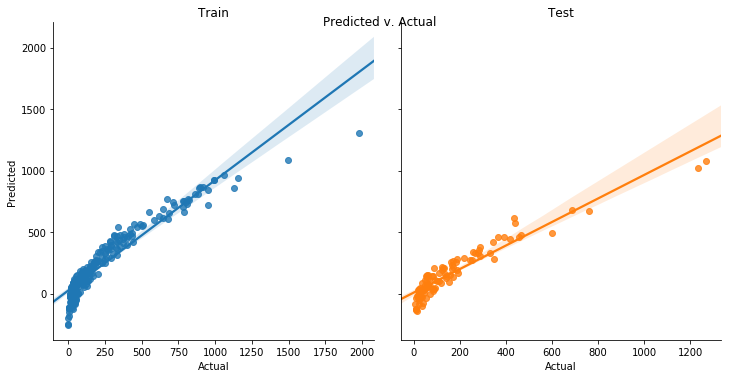

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.tight_layout()
fig.suptitle("Predicted v. Actual")
sns.regplot(ohio_train["property_crime"], lm3.fittedvalues, ax=ax1)
ax1.set_title("Train")
sns.despine(ax=ax1)

sns.regplot(actual3, predicted3, ax=ax2)
ax1.set(xlabel="Actual", ylabel="Predicted")
sns.despine(ax=ax2)
ax2.set_xlabel("Actual")
ax2.set_title("Test")
plt.show()

In [43]:
predicted4 = lm4.predict(ohio_test)
actual4 = ohio_test["property_crime_log"]
residuals4 = actual4 - predicted4

print("MODEL EVALUATION\n--------------------\nr^2: 0.959")
print("\nTRAIN\n--------------------")
print("Mean Residual: {}".format(np.exp(lm4.resid.mean())))
print("RMSE: {}".format(round(np.exp(lm4.resid.std()),2)))

print("\n\nTEST\n--------------------")
print("Mean Residual: {}".format(np.exp(residuals4.mean())))
print("RMSE: {}".format(round(np.exp(residuals4.std()),2)))

MODEL EVALUATION
--------------------
r^2: 0.959

TRAIN
--------------------
Mean Residual: 0.9999999999999953
RMSE: 1.32


TEST
--------------------
Mean Residual: 1.0244257146817972
RMSE: 1.25


/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


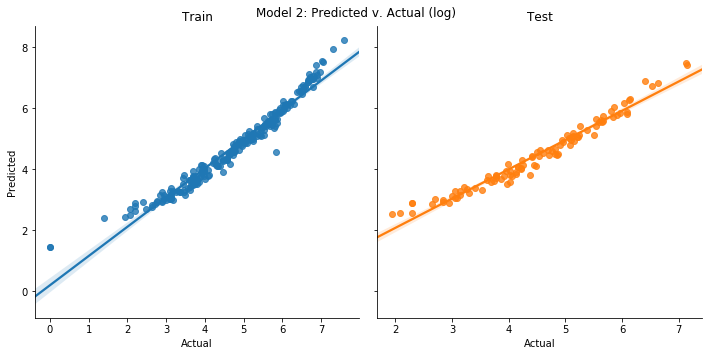

In [44]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.suptitle("Model 2: Predicted v. Actual (log)")
sns.regplot(ohio_train["property_crime_log"], lm4.fittedvalues, ax=ax1)
ax1.set_title("Train")
sns.despine(ax=ax1)

sns.regplot(actual4, predicted4, ax=ax2)
ax1.set(xlabel="Actual", ylabel="Predicted")
sns.despine(ax=ax2)
ax2.set_xlabel("Actual")
ax2.set_title("Test")
fig.tight_layout()
plt.show()

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


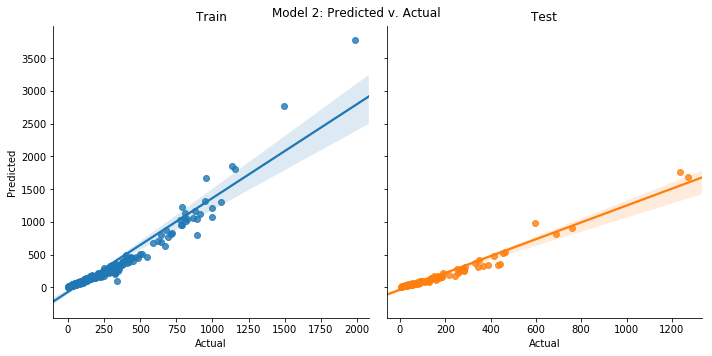

In [45]:
predicted5 = np.exp(lm4.predict(ohio_test))
actual5 = ohio_test["property_crime"]
residuals5 = actual5 - predicted5

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.suptitle("Model 2: Predicted v. Actual")
sns.regplot(ohio_train["property_crime"], np.exp(lm4.fittedvalues), ax=ax1)
ax1.set_title("Train")
sns.despine(ax=ax1)

sns.regplot(actual5, predicted5, ax=ax2)
ax1.set(xlabel="Actual", ylabel="Predicted")
sns.despine(ax=ax2)
ax2.set_xlabel("Actual")
ax2.set_title("Test")
fig.tight_layout()
plt.show()

## Conclusions

This model appears to perform better on the Michigan data. 